## Key words
- mnist
- customerized CNN, Alexnet
- load python file in python notebook
- hidden layers visualization

### packages and globe settings

In [ ]:
%load shared.py
%load_ext autoreload
%autoreload 2

from shared import *

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
from torch.utils import data
from torchkeras import summary, Model
from sklearn.metrics import precision_score, accuracy_score
import pandas as pd
import os
import datetime


MNIST_ROOT = os.path.join('..', 'data')
MNIST_PATH = os.path.join(MNIST_ROOT, 'MNIST')

HISTORY_FILE = os.path.join(MNIST_PATH, 'c3_mnist_history.csv')
WEIGHT_FILE = os.path.join(MNIST_PATH, 'c3_mnist_weight.pth')

HISTORY1_FILE = os.path.join(MNIST_PATH, 'c3_mnist_history1.csv')
HISTORY2_FILE = os.path.join(MNIST_PATH, 'c3_mnist_history2.csv')

WEIGHT1_FILE = os.path.join(MNIST_PATH, 'c3_mnist_weight1.pth')
WEIGHT2_FILE = os.path.join(MNIST_PATH, 'c3_mnist_weight2.pth')

NB_CLASSES = 10
NROWS = 8

IMAGE_MEAN = 0.5
IMAGE_STD = 0.5
IMAGE_CHANNEL = 1
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28

BATCH_SIZE = 32
VAL_BATCH_SIZE = 32
LR = 1e-2

### datasets and dataloader

In [ ]:
# datasets and dataloader
data_tf = transforms.Compose([
    transforms.ToTensor(),  # 0~255 -> 0~1
    transforms.Normalize((IMAGE_MEAN, ), (IMAGE_STD, ))  # 0~1 -> -1~1
])

ds_train = datasets.MNIST(MNIST_ROOT, train=True, transform=data_tf, download=True)
ds_valid = datasets.MNIST(MNIST_ROOT, train=False, transform=data_tf, download=True)

dl_train = data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
dl_valid = data.DataLoader(ds_valid, batch_size=VAL_BATCH_SIZE, shuffle=True)

### network class

In [ ]:
# network
class SimpleCNN(nn.Module):
    def __init__(self, nb_classes=10, *args, **kwargs):
        super(SimpleCNN, self).__init__(*args, **kwargs)
        self.epoch = 0
        
        self.conv1 = nn.Conv2d(IMAGE_CHANNEL, 32, 3)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(2)

        self.flatten1 = nn.Flatten()

        self.fc1 = nn.Linear(5408, 32)
        self.fc2 = nn.Linear(32, nb_classes)

        self.logsoftmax1 = nn.LogSoftmax(dim=1)

    def forward(self, input):
        input = self.conv1(input)
        input = self.relu1(input)
        input = self.max_pool1(input)

        input = self.flatten1(input)

        input = self.fc1(input)
        input = self.fc2(input)

        input = self.logsoftmax1(input)

        return input

In [ ]:
Model(SimpleCNN(NB_CLASSES)).summary(input_shape=(IMAGE_CHANNEL, IMAGE_WIDTH, IMAGE_HEIGHT))

### model training and save history and weights

In [ ]:
# training settings (loss, optim & metrics)
model = SimpleCNN(NB_CLASSES)
model.loss_fn = nn.CrossEntropyLoss()
model.optim = optim.Adam(model.parameters(), lr=LR)
model.metrics_dict = {
    'precision': precision_metrics,
    'accuracy': accuracy_metrics
}

# model training
history = train_model(model, dl_train, dl_valid, epochs=20, log_per_epochs=1, log_per_steps=200)

# save training history
save_history(model, HISTORY1_FILE)

# save weights
save_weight(model, WEIGHT1_FILE)

### ouputs of hidden layers

In [ ]:
# forward hook
def hook_fn(module, input, output):
    print(module)
    output_shape = output.data.shape
    plot_images(output.data.reshape(-1, 1, output_shape[-2], output_shape[-1]), mean=IMAGE_MEAN, std=IMAGE_STD, nrows=output_shape[0], figsize=(10, 10))


model = SimpleCNN(NB_CLASSES)
model.metrics_dict = {
    'precision': precision_metrics,
    'accuracy': accuracy_metrics
}

model = load_weight(model, WEIGHT1_FILE, net_only=True)

# hooks = {}
# for name, module in model.named_children():
#     hooks[name] = module.register_forward_hook(hook_fn)

features, labels = next(iter(dl_valid))
# plot origin
plot_images(features, mean=IMAGE_MEAN, std=IMAGE_STD, nrows=VAL_BATCH_SIZE, figsize=(10, 2))

# plot outputs of layers conv1, relu1, max_pool1
model.conv1.register_forward_hook(hook_fn)
model.relu1.register_forward_hook(hook_fn)
model.max_pool1.register_forward_hook(hook_fn)

eval_model(model, features, labels)

### visualization of Alexnet hidden layers

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
from torch.utils import data
from torchkeras import summary, Model
from sklearn.metrics import precision_score, accuracy_score
import pandas as pd
import os
import datetime

Model(models.alexnet()).summary(input_shape=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([1, 64, 27, 27])


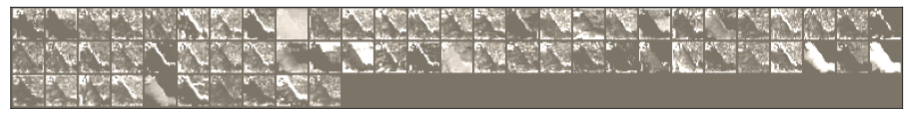

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([1, 192, 13, 13])


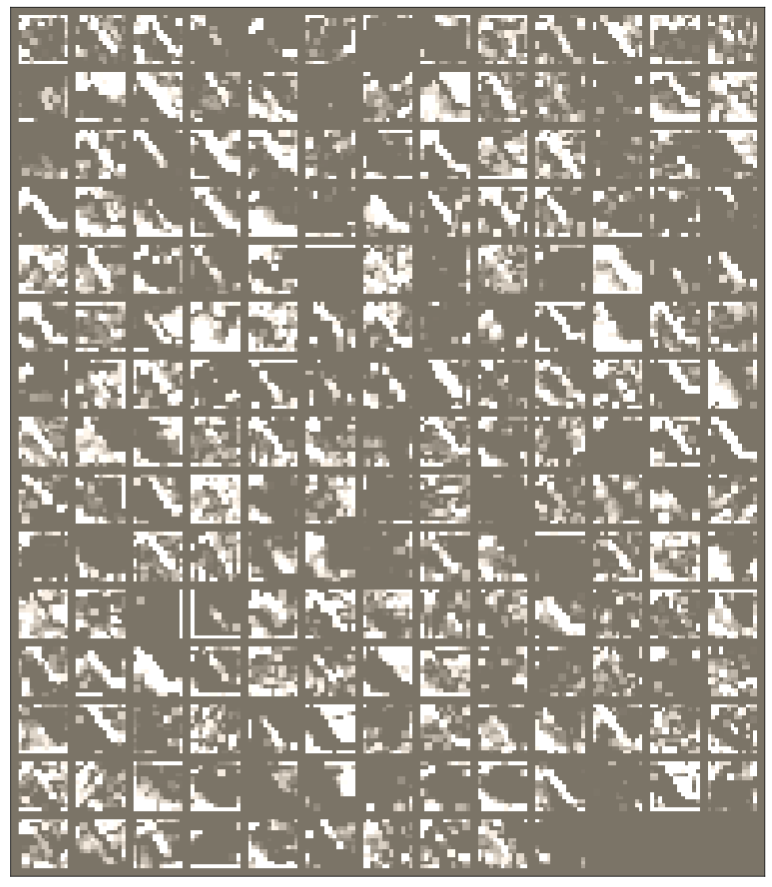

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ReLU(inplace=True)
torch.Size([1, 384, 13, 13])


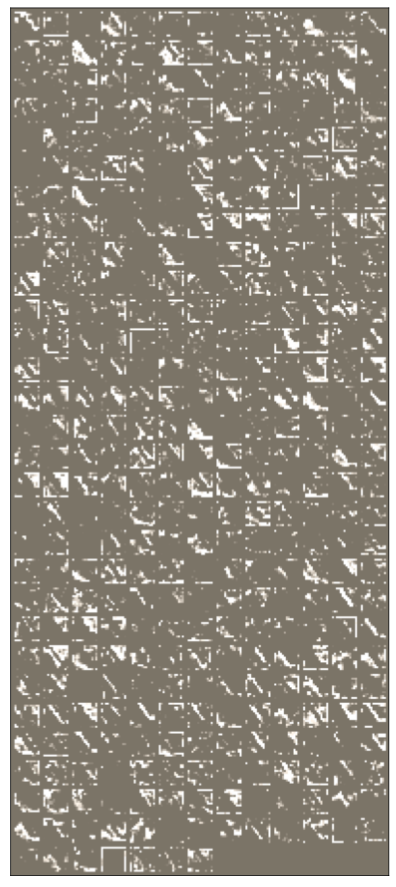

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ReLU(inplace=True)
torch.Size([1, 256, 13, 13])


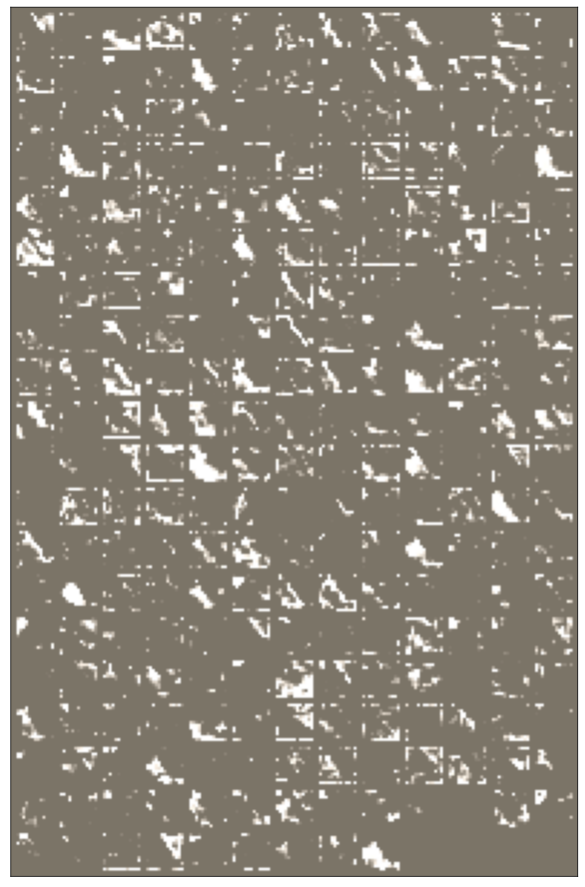

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([1, 256, 6, 6])


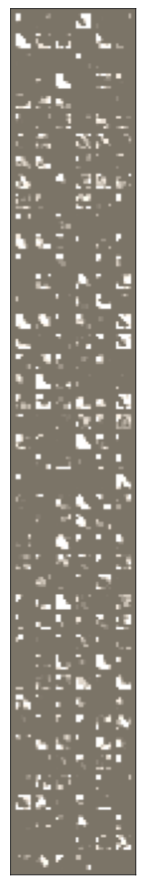

tensor([258])

In [17]:
IMAGE_CHANNEL = 3
IMAGE_MEAN = (0.485, 0.456, 0.406)
IMAGE_STD = (0.229, 0.224, 0.225)

def hook_fn(module, input, output):
    print(module)
    output_shape = output.data.shape
    print(output_shape)
    plot_images(output.data.reshape(-1, 1, output_shape[-2], output_shape[-1]), mean=IMAGE_MEAN, std=IMAGE_STD, nrows=output_shape[-1], figsize=(16, 16))

# ds, dl
DATASET_ROOT = os.path.join('..', 'data')
DATASET_PATH = os.path.join(DATASET_ROOT, 'custom')

data_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGE_MEAN, std=IMAGE_STD),
])

ds = datasets.ImageFolder(DATASET_PATH, transform=data_tf)
dl = data.DataLoader(ds)

features, _ = next(iter(dl))
# plot_images(features, IMAGE_MEAN, IMAGE_STD)

model = models.alexnet(pretrained=True)
model.features[2].register_forward_hook(hook_fn)
model.features[5].register_forward_hook(hook_fn)
model.features[7].register_forward_hook(hook_fn)
model.features[9].register_forward_hook(hook_fn)
model.features[12].register_forward_hook(hook_fn)

# features.shape
predict_model(model, features)